In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install prettytable


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python scikit-image matplotlib


Note: you may need to restart the kernel to use updated packages.Collecting opencv-python
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   - -------------------------------------- 1.4/38.6 MB 28.5 MB/s eta 0:00:02
   -- ------------------------------------- 2.3/38.6 MB 24.5 MB/s eta 0:00:02
   --- ------------------------------------ 3.7/38.6 MB 26.5 MB/s eta 0:00:02
   ----- ---------------------------------- 5.2/38.6 MB 30.4 MB/s eta 0:00:02
   ------- -------------------------------- 7.5/38.6 MB 31.8 MB/s eta 0:00:01
   --------- ------------------------------ 9.2/38.6 MB 34.7 MB/s eta 0:00:01
   ----------- ---------------------------- 11.4/38.6 MB 36.3 MB/s eta 0:00:01
   ------------- -------------------------- 13.5/38.6 MB 40.9 MB/s eta 0:00:01
   ---------------- ----------------------- 16.1/38.6 MB 50.4 MB/s eta 0:00:01
   ------------------- -------------------- 18.6/38.6 MB 50.4 MB/s eta 0:00:01
   --------------------- ------------------ 20.6/38.6 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


# <font color="orange">Importing Libraries</font>

In [5]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import numpy as np
import pandas as pd
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import math
import seaborn as sns
from tensorflow.keras.callbacks import Callback,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from prettytable import PrettyTable

# <font color="yellow">Some Initial investigation of the Images</font>

No. of tumor images=1500
No. of healthy images=1500
Different extensions of images are: ['jpg']

-------------------------------------------------------------------------

Tumor Scans:-
-----------------


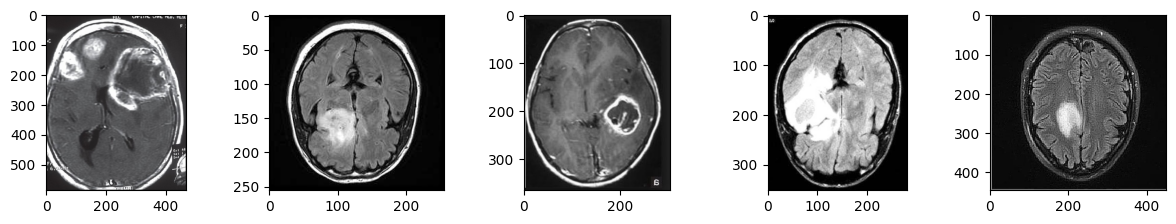


Healthy Scans:-
-----------------


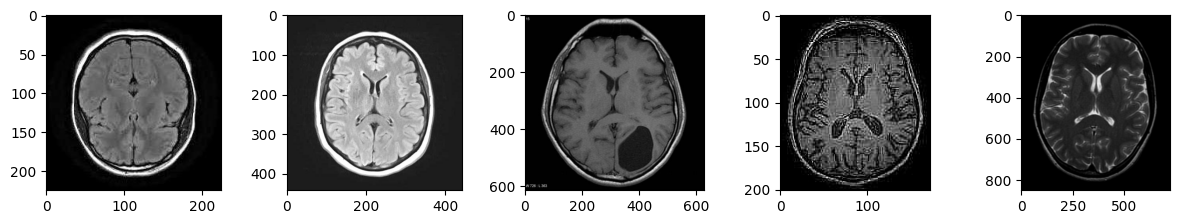

In [7]:
tumor_folder = "D:\\major_project\\BrainTumorProject\\datasets\\yes"
healthy_folder = "D:\\major_project\\BrainTumorProject\\datasets\\no"
tumor_listdir = os.listdir(tumor_folder)
healthy_listdir = os.listdir(healthy_folder)
print(f"No. of tumor images={len(tumor_listdir)}")
print(f"No. of healthy images={len(healthy_listdir)}")

tumor_img_extensions = list(set([img.split(".")[1] for img in tumor_listdir]))
healthy_img_extensions = list(set([img.split(".")[1] for img in healthy_listdir]))
diff_extensions = list(set(tumor_img_extensions+healthy_img_extensions))
print(f"Different extensions of images are: {diff_extensions}")
print()
print("-------------------------------------------------------------------------")
print()

# let's look at some tumorous and healthy MRI photos
def plot_photos(folder):
  images = os.listdir(folder)
  plt.subplots(figsize=(15, 5))
  # plot any 5 images
  for i in range(1,6):
    # define subplot
    plt.subplot(2,5,i)
    choice = random.randint(0,len(images)-1)
    chosenImg = images[choice]
    # define file path
    filename = folder + "/" + chosenImg
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
  # show the figure
  plt.show()
print("Tumor Scans:-")
print("-----------------")
plot_photos(tumor_folder)
print()
print("Healthy Scans:-")
print("-----------------")
plot_photos(healthy_folder)  

# <font color="orange">Creating Standard directories</font>

In [9]:
import os
import random
import shutil

# Copy tumor images to the temp folder
shutil.copytree(tumor_folder, 'temp')

# Move healthy images to the temp folder
for file in os.listdir(healthy_folder):
    src = os.path.join(healthy_folder, file)
    try:
        shutil.copy(src, "temp")
    except Exception as e:
        print(f"Error copying {src} to temp: {e}")

# # Debug: Print contents of the temp folder
# print("\nContents of the temp folder:")
# print(os.listdir("temp"))

# Sanity check      
print("Total No. of images in this temp folder =", len(os.listdir("temp")))

# Creating directories
dataset_home = "tumor_vs_healthy/"
subdirs = ["train/", "validate/"]
for subdir in subdirs:
    # Create label subdirectories
    labeldirs = ["tumor/", "healthy/"]
    for labldir in labeldirs:
        newdir = os.path.join(dataset_home, subdir, labldir)
        os.makedirs(newdir, exist_ok=True)

# Seed random number generator
random.seed(1)
# Defining 80-20 ratio of train-test split
val_ratio = 0.20

# Get the list of files in the temp folder
src_directory = "temp"
files = os.listdir(src_directory)
num_val = int(len(files) * val_ratio)
val_files = random.sample(files, num_val)

# Debug: Print a few sample file names and their corresponding labels
print("\nDebug: Sample file names and labels")
sample_files = random.sample(files, min(5, len(files)))
for file in sample_files:
    label = "tumor" if file.lower().startswith("y") else "healthy"

    print(f"File: {file}, Label: {label}, Destination: {'validate' if file in val_files else 'train'}")

# Copy the images from the temp folder into respective subdirectories for train and test
for file in files:
    src = os.path.join(src_directory, file)
    dst_dir = "validate" if file in val_files else "train"

    # Determine the label based on the file name
    label = "tumor" if file.startswith("y") else "healthy"

    dst = os.path.join(dataset_home, dst_dir, label, file)
    shutil.copyfile(src, dst)

# Debug: Print contents of the train and test folders
print("\nContents of the train folder:")
print(os.listdir(os.path.join(dataset_home, "train")))

print("Contents of the test folder:")
print(os.listdir(os.path.join(dataset_home, "validate")))

# Sanity check
print("\nSanity for no. of images in each folder:-")
print("Train")
print("Healthy -->", len(os.listdir(os.path.join(dataset_home, "train", "healthy"))))
print("Tumor -->", len(os.listdir(os.path.join(dataset_home, "train", "tumor"))))
print("validate")
print("Healthy -->", len(os.listdir(os.path.join(dataset_home, "validate", "healthy"))))
print("Tumor -->", len(os.listdir(os.path.join(dataset_home, "validate", "tumor"))))


Total No. of images in this temp folder = 3000

Debug: Sample file names and labels
File: y1265.jpg, Label: tumor, Destination: validate
File: y432.jpg, Label: tumor, Destination: validate
File: no1075.jpg, Label: healthy, Destination: train
File: no1110.jpg, Label: healthy, Destination: train
File: y611.jpg, Label: tumor, Destination: train

Contents of the train folder:
['healthy', 'tumor']
Contents of the test folder:
['healthy', 'tumor']

Sanity for no. of images in each folder:-
Train
Healthy --> 1199
Tumor --> 1201
validate
Healthy --> 301
Tumor --> 299


# <font color="yellow">Pre-processing the Data</font>

IMAGE PREPROCESSING

image database(mri images)


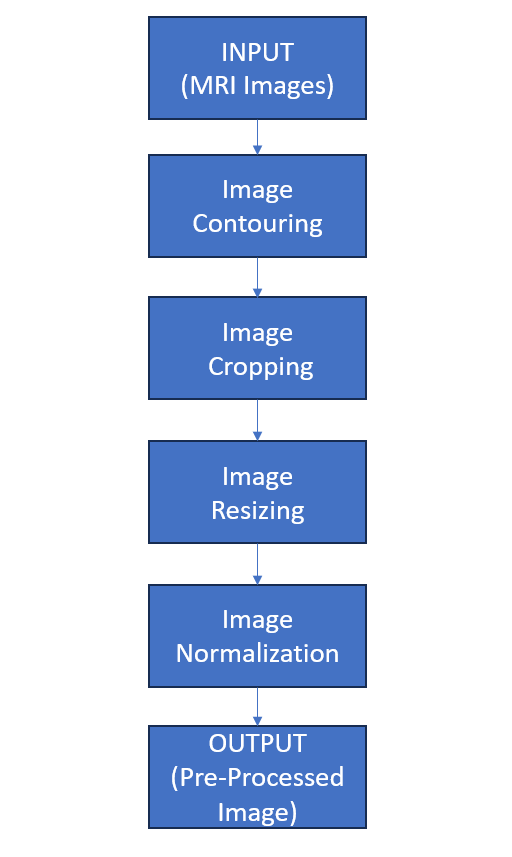

# <font color="orange">Cropping the brain out of the images</font>

In [31]:
pip install imutils


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=f206c69a5650df433f2932157d1cf993554424c300188dd826570b07be31bc9b
  Stored in directory: c:\users\madhu\appdata\local\pip\cache\wheels\31\d0\2c\87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


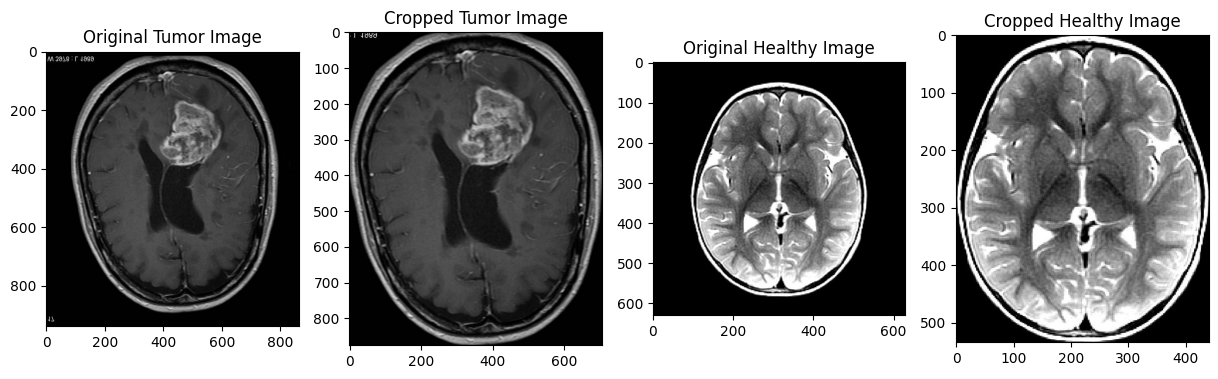

In [11]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

# Function for cropping images based on extreme points
def crop_imgs(img_set, add_pixels_value=0):
    set_new = []
    for img in img_set:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Threshold the image, then perform a series of erosions + dilations to remove small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # Find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

# Path to a random tumor image
img_path_tumor = "tumor_vs_healthy/train/tumor/y141.jpg"  # Replace with the actual path
img_tumor = cv2.imread(img_path_tumor)
img_tumor = cv2.cvtColor(img_tumor, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Path to a random healthy image
img_path_healthy = "tumor_vs_healthy/train/healthy/no0.jpg"  # Replace with the actual path
img_healthy = cv2.imread(img_path_healthy)
img_healthy = cv2.cvtColor(img_healthy, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Crop images
cropped_tumor = crop_imgs([img_tumor])[0]
cropped_healthy = crop_imgs([img_healthy])[0]

# Display original and cropped images
plt.figure(figsize=(15, 6))
plt.subplot(141)
plt.imshow(img_tumor)
plt.title('Original Tumor Image')
plt.subplot(142)
plt.imshow(cropped_tumor)
plt.title('Cropped Tumor Image')
plt.subplot(143)
plt.imshow(img_healthy)
plt.title('Original Healthy Image')
plt.subplot(144)
plt.imshow(cropped_healthy)
plt.title('Cropped Healthy Image')
plt.show()


In [4]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

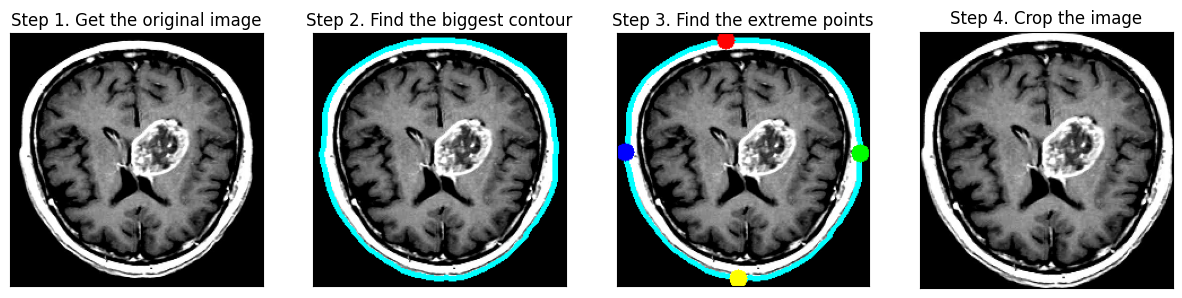

In [7]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)
IMG_SIZE = (224,224)
img = cv2.imread("D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y18.jpg")
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

# <font color="orange">IMAGE PREPROCESSING USING VGG-16</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


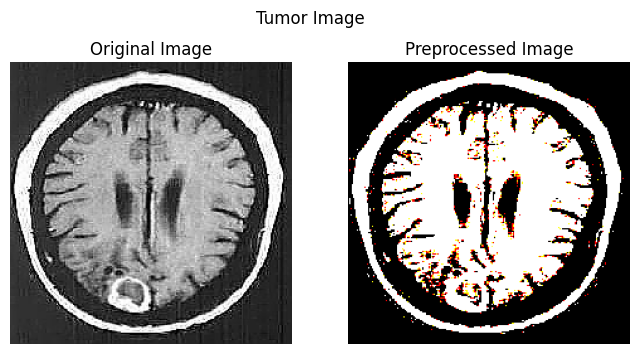

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


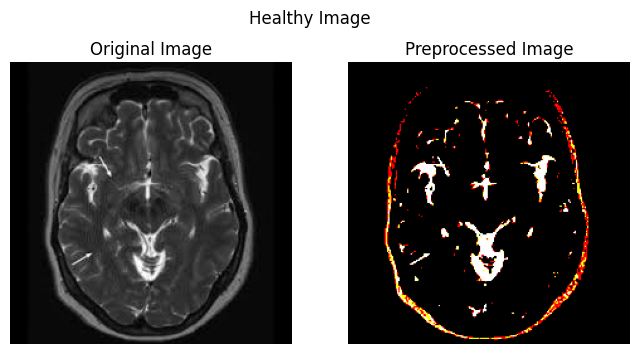

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Function for image preprocessing
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Load image and resize to VGG-16 input size
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
    img_preprocessed = preprocess_input(img_array)  # Preprocess image using VGG-16 preprocessing function
    return img, img_preprocessed

# Function to plot original and preprocessed images
def plot_images(original_img, preprocessed_img, title):
    plt.figure(figsize=(8, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # Preprocessed image
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(preprocessed_img))  # Remove the batch dimension for display
    plt.title("Preprocessed Image")
    plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Path to the dataset
dataset_home = "tumor_vs_healthy/"

# Path to a random tumor image
tumor_images = os.listdir(os.path.join(dataset_home, "train", "tumor"))
random_tumor_img = random.choice(tumor_images)
img_path_tumor = os.path.join(dataset_home, "train", "tumor", random_tumor_img)

# Path to a random healthy image
healthy_images = os.listdir(os.path.join(dataset_home, "train", "healthy"))
random_healthy_img = random.choice(healthy_images)
img_path_healthy = os.path.join(dataset_home, "train", "healthy", random_healthy_img)

# Preprocess images
original_tumor_img, preprocessed_tumor_img = preprocess_image(img_path_tumor)
original_healthy_img, preprocessed_healthy_img = preprocess_image(img_path_healthy)

# Display preprocessed images
plot_images(original_tumor_img, preprocessed_tumor_img, "Tumor Image")
plot_images(original_healthy_img, preprocessed_healthy_img, "Healthy Image")


In [16]:
pip install SimpleITK



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/18.1 MB ? eta -:--:--
   - -------------------------------------- 0.6/18.1 MB 20.5 MB/s eta 0:00:01
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   -- ------------------------------------- 1.0/18.1 MB 16.7 MB/s eta 0:00:02
   ---- ----------------------------------- 2.0/18.1 MB 5.0 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/18.1 MB 4.9 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/18.1 MB 4.9 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/18.1 MB 4.9 MB/s eta 0:00:

images and their count


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to be between 0 and 1
    shear_range=0.2,            # Shear intensity (shear angle in radians)
    zoom_range=0.2,             # Randomly zoom inside images
    horizontal_flip=True       # Randomly flip half of the images horizontally
)

# Define the ImageDataGenerator for validation/test data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

# Define the training generator
train_generator = train_datagen.flow_from_directory(
    'tumor_vs_healthy/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'  # Assumes you have binary classification (tumor vs. healthy)
)

# Define the validation generator
validation_generator = validation_datagen.flow_from_directory(
    'tumor_vs_healthy/validate',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [11]:
# just a sanity for deciding No. of batches or steps_per_epoch:-
print("No. of batches or steps_per_epoch for train set should be-->","2400/32=",2400/32,
      "i.e.",math.ceil(2400/32), ",which is simply", "len(train_it)=",len(train_generator))
print("No. of batches or steps_per_epoch for validation set should be-->","600/32=",600/32,
      "i.e.",math.ceil(600/32), ",which is simply", "len(test_it)=",len(validation_generator))



No. of batches or steps_per_epoch for train set should be--> 2400/32= 75.0 i.e. 75 ,which is simply len(train_it)= 75
No. of batches or steps_per_epoch for validation set should be--> 600/32= 18.75 i.e. 19 ,which is simply len(test_it)= 19


# <font color="white">Brain Tumor Identification in MRI Images through Image Processing<font>

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: opencv-python in c:\users\madhu\appdata\local\programs\python\python311\lib\site-packages (4.9.0.80)




[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import cv2

In [16]:
img_path = "D:/major_project/BrainTumorProject/datasets/yes/y104.jpg"  # Note the forward slashes or use raw string
image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim = (500, 590)
image_resized = cv2.resize(image, dim)
cv2.imshow('Resized Image', image_resized)
cv2.waitKey(0)
cv2.destroyAllWindows()


width: 310 pixels
height: 380 pixels
channels: 3


# <font color="white">Thresholding<font>

In [17]:
import cv2

img_path = "D:/major_project/BrainTumorProject/datasets/yes/y104.jpg"
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow('Grayscale Image', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
cv2.imshow('Thresholded Image', thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
cv2.imshow('Inverted Thresholded Image', threshInv)
cv2.waitKey(0)
cv2.destroyAllWindows()


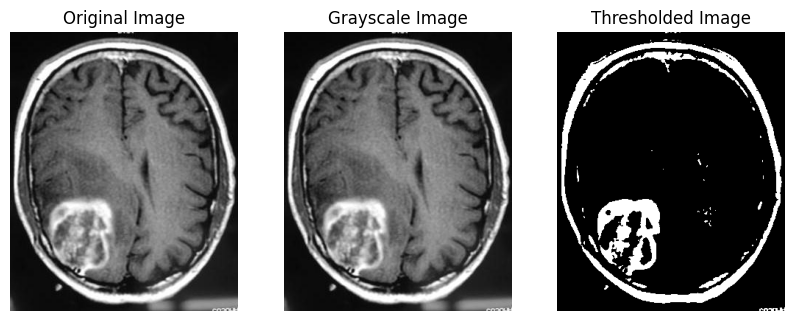

In [4]:
import cv2
import matplotlib.pyplot as plt

# Read the image
img_path = "D:/major_project/BrainTumorProject/datasets/yes/y104.jpg"
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
(T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY)
(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)

# Display images side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale image
plt.subplot(1, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Thresholded image
plt.subplot(1, 3, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()


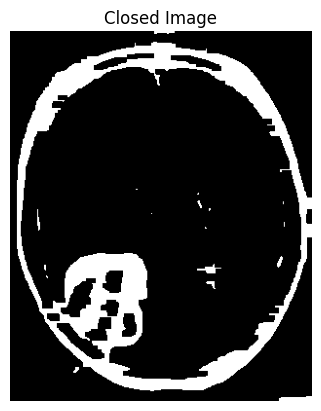

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
import matplotlib.pyplot as plt

plt.imshow(closed, cmap='gray')
plt.title('Closed Image')
plt.axis('off')
plt.show()


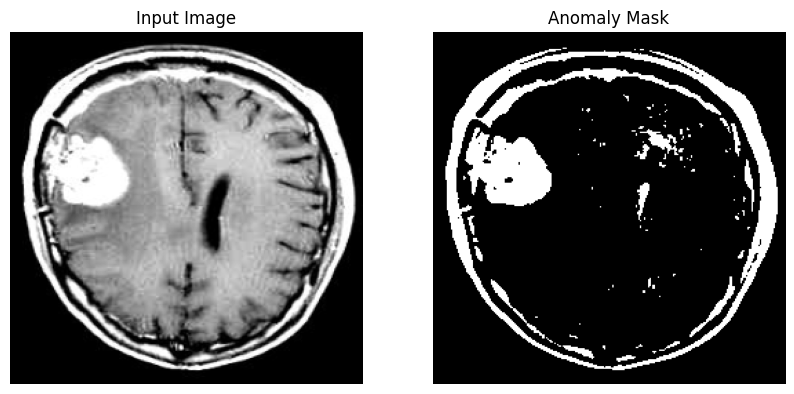

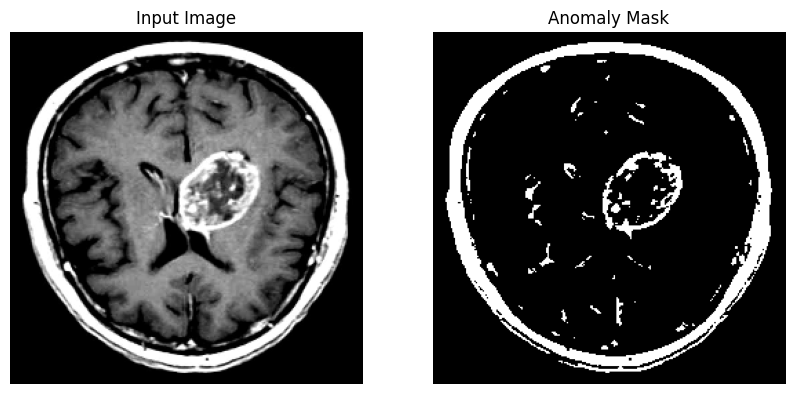

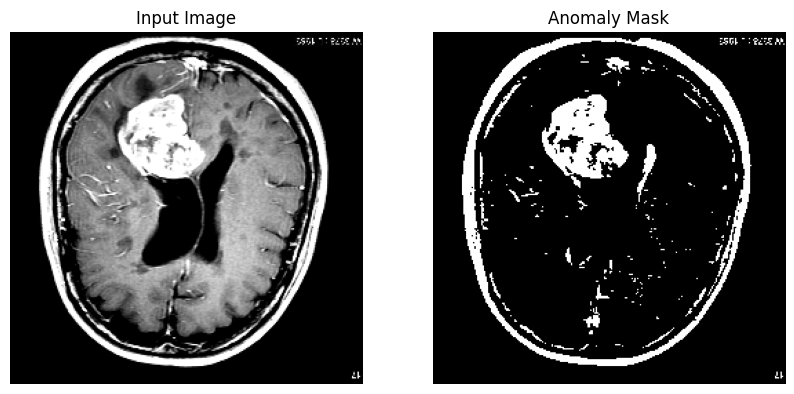

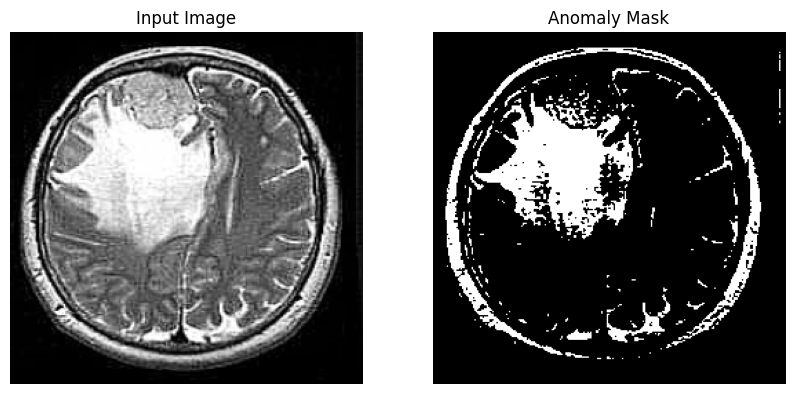

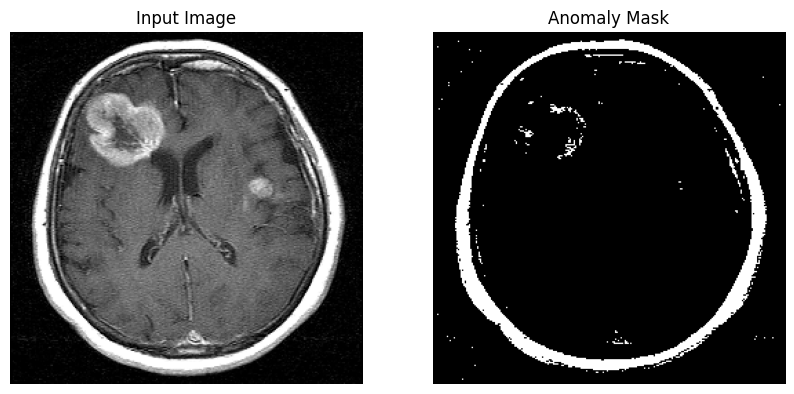

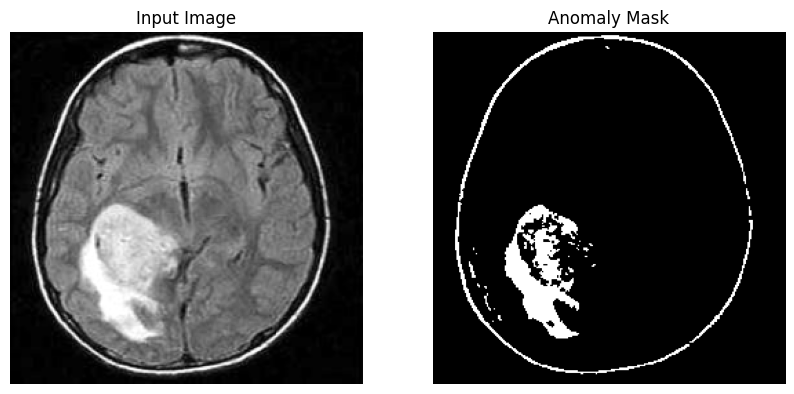

In [18]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess 'no' labeled images for training
def load_train_data(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (256, 256))  # Resize for consistency
            images.append(image)
    return np.array(images)

# Train the model (e.g., using mean and standard deviation)
def train_model(images):
    mean_image = np.mean(images, axis=0)
    std_image = np.std(images, axis=0)
    return mean_image, std_image

# Detect anomalies (potential tumor regions)
def detect_anomalies(image, mean_image, std_image, threshold):
    diff_image = np.abs(image - mean_image)
    anomaly_mask = (diff_image > threshold * std_image).astype(np.uint8) * 255
    return anomaly_mask

# Load 'yes' labeled images for inference
def load_inference_data(image_paths):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))  # Resize for consistency
        images.append(image)
    return np.array(images)

# Load 'no' labeled images for training
train_directory = "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\healthy"
train_images = load_train_data(train_directory)

# Train the model
mean_image, std_image = train_model(train_images)

# Specify paths to the 5 specific 'yes' labeled images for inference
image_paths = [
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y2.jpg",
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y18.jpg",
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y26.jpg",
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y1224.jpg",
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y1132.jpg",
    "D:\\major_project\\BrainTumorProject\\tumor_vs_healthy\\train\\tumor\\y308.jpg"

]

# Load the specified 'yes' labeled images for inference
inference_images = load_inference_data(image_paths)

# # Detect anomalies (potential tumor regions) in inference images
# threshold = 2  # Adjust threshold based on sensitivity
# for image, image_path in zip(inference_images, image_paths):
#     anomaly_mask = detect_anomalies(image, mean_image, std_image, threshold)
#     plt.figure()
#     plt.imshow(anomaly_mask, cmap='gray')
#     plt.title(f'Anomaly Mask - {image_path}')
#     plt.axis('off')
#     plt.show()


# Detect anomalies (potential tumor regions) in inference images
threshold = 2  # Adjust threshold based on sensitivity
for image, image_path in zip(inference_images, image_paths):
    anomaly_mask = detect_anomalies(image, mean_image, std_image, threshold)
    
    # Plot the input and output images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    axes[1].imshow(anomaly_mask, cmap='gray')
    axes[1].set_title('Anomaly Mask')
    axes[1].axis('off')
    
    # Print the plot to the VS Code output panel
    plt.show()





# <font color="orange">Defining Model Architectures & Evaluation<font>

In [3]:
# # plotting diagnostic curves
# def summarize_diagnostics(history):
#   plt.subplot(1,2,1)
#   plt.title("Epoch vs Binary Cross Entropy Loss")
#   plt.plot(history.history['loss'],color="blue",label="train")
#   plt.plot(history.history['val_loss'],color="orange",label="test")
#   plt.xlabel("Epoch")
#   plt.legend()
#   plt.subplot(1,2,2)
#   plt.title("Epoch vs Accuracy")
#   plt.plot(history.history['accuracy'],color="blue",label="train")
#   plt.plot(history.history['val_accuracy'],color="orange",label="test")
#   plt.xlabel("Epoch")
#   plt.legend()
#   plt.show()



# function for plotting diagnostic curves --> a re-usable function
def summarize_diagnostics(history):
  plt.subplot(1,2,1)
  plt.title("Epoch vs Binary Cross Entropy Loss")
  plt.plot(history.history['loss'],color="blue",label="train")
  plt.plot(history.history['val_loss'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.subplot(1,2,2)
  plt.title("Epoch vs Accuracy")
  plt.plot(history.history['accuracy'],color="blue",label="train")
  plt.plot(history.history['val_accuracy'],color="orange",label="test")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

In [13]:
#callback to stop the training if your validation accuracy is not increased in last 2 epochs
# callback1 = EarlyStopping( monitor="val_accuracy",
#                            patience=2,
#                            verbose=1,
#                            mode="auto",
#                            min_delta=0 )

# #callback to decay learning based on below conditions 
# #Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
# #Cond2. For every 3rd epoch, decay learning rate by 5%
# #for Cond1:-
# callback2 = ReduceLROnPlateau( monitor="val_accuracy",
#                               factor=0.1,
#                               patience=1,
#                               verbose=1,
#                               mode="auto"
#                               )
# #for Cond2:-
# def lf_schedule(epoch,lr):
#   if epoch%3 ==0:
#     lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
#     print(f'New learning rate for epoch={epoch} is {lr}')
#     return lr
#   else:
#     return lr
# callback3 = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

# #callback to save the model at every epoch if validation accuracy is improved from previous epoch
# #file path to save the best model for ModelCheckPoint:-
# !mkdir "model_save/"
# f_path = "model_save/best_model.h5"
# callback4 = ModelCheckpoint( filepath=f_path,
#                              monitor="val_accuracy",
#                              verbose=1,
#                              save_best_only=True,
#                              mode="auto"
#                            )


"hello"


#callback to stop the training if your validation accuracy is not increased in last 2 epochs
# callback1 = EarlyStopping( monitor="val_accuracy",
#                            patience=5,
#                            verbose=1,
#                            mode="auto",
#                            min_delta=0)

#callback to decay learning based on below conditions 
#Cond1. If validation accuracy at that epoch is less than previous epoch accuracy, decrease the learning rate by 10%. 
#Cond2. For every 3rd epoch, decay learning rate by 5%
#for Cond1:-
# callback2 = ReduceLROnPlateau( monitor="val_accuracy",
#                               factor=0.1,
#                               patience=1,
#                               verbose=1,
#                               mode="auto"
#                               )
#for Cond2:-
def lf_schedule(epoch,lr):
  if epoch%10 ==0:
    lr=lr - 0.05*lr #-->i.e. 0.95*lr (5% decay)
    print(f'New learning rate for epoch={epoch} is {lr}')
    return lr
  else:
    return lr
callback_lrs = LearningRateScheduler( schedule=lf_schedule,verbose=1 )

#callback to save the model at every epoch if validation accuracy is improved from previous epoch
#file path to save the best model for ModelCheckPoint:-
# !mkdir "model_save/"
# f_path = "model_save/best_model.h5"
# callback4 = ModelCheckpoint( filepath=f_path,
#                              monitor="val_accuracy",
#                              verbose=1,
#                              save_best_only=True,
#                              mode="auto"
#                            )




### <b><font color="#dd11a3">Model-1 --> Simple Convolutional Neural Network (CNN) for Binary Classification</font><b>

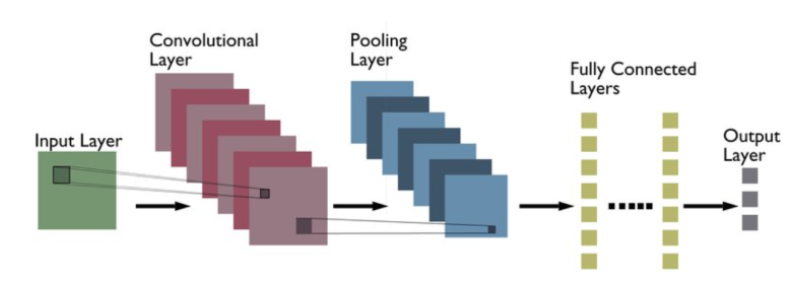

Reference : https://github.com/MohamedAliHabib/Brain-Tumor-Detection

In [32]:
pip install scipy


Note: you may need to restart the kernel to use updated packages.


In [33]:
import scipy

Found 2400 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Epoch 1/20
75/75 [==============================] - 217s 3s/step - loss: 1.4670 - accuracy: 0.8008 - val_loss: 0.2801 - val_accuracy: 0.8972
Epoch 2/20
75/75 [==============================] - 194s 3s/step - loss: 0.1135 - accuracy: 0.9629 - val_loss: 0.1058 - val_accuracy: 0.9802
Epoch 3/20
75/75 [==============================] - 191s 3s/step - loss: 0.0287 - accuracy: 0.9946 - val_loss: 0.0663 - val_accuracy: 0.9763
Epoch 4/20
75/75 [==============================] - 191s 3s/step - loss: 0.0067 - accuracy: 0.9992 - val_loss: 0.0651 - val_accuracy: 0.9763
Epoch 5/20
75/75 [==============================] - 192s 3s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0763 - val_accuracy: 0.9763
Epoch 6/20
75/75 [==============================] - 191s 3s/step - loss: 8.3719e-04 - accuracy: 1.0000 - val_loss: 0.0791 - val_accuracy: 0.9763
Epoch 7/20
75/75 [==============================] - 193s 3s/step - 

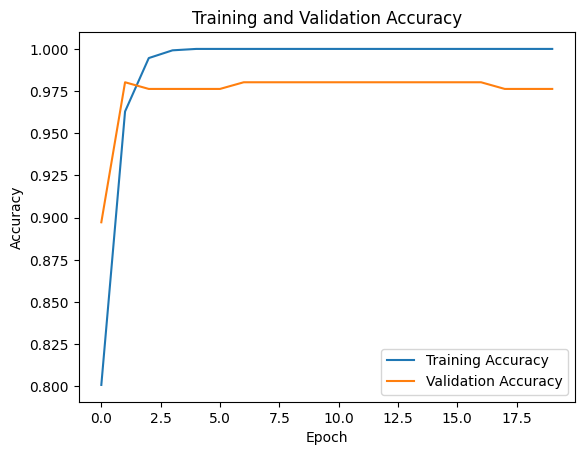

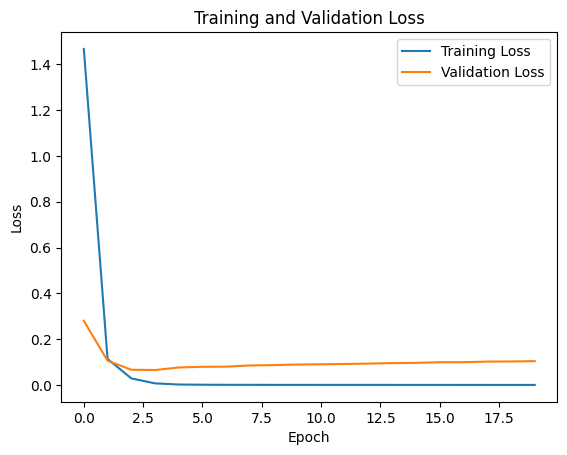

8/8 [==============================] - 2s 270ms/step - loss: 0.1040 - accuracy: 0.9763
Model-1 Evaluation:
Test Accuracy: 0.9762845635414124
Test Loss: 0.10402413457632065


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define Model-1
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set the batch size
batch_size = 32

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)

# Define the ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the training generator
train_generator = train_datagen.flow_from_directory(
    'tumor_vs_healthy/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'  # Assumes binary classification (tumor vs. healthy)
)

# Define the test generator
test_generator = test_datagen.flow_from_directory(
    'D:\\major_project\\BrainTumorProject\\test_dataset',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Calculate steps per epoch for training
steps_per_epoch = len(train_generator)

# Train Model-1
history1 = model1.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator
)

# Plot the training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model-1 on the test set
evaluation1 = model1.evaluate(test_generator)
print("Model-1 Evaluation:")
print("Test Accuracy:", evaluation1[1])
print("Test Loss:", evaluation1[0])



### <b><font color="#dd11a3">Model-2 --> CNN with Multiple Layers + Dropout Regularization</font></b>

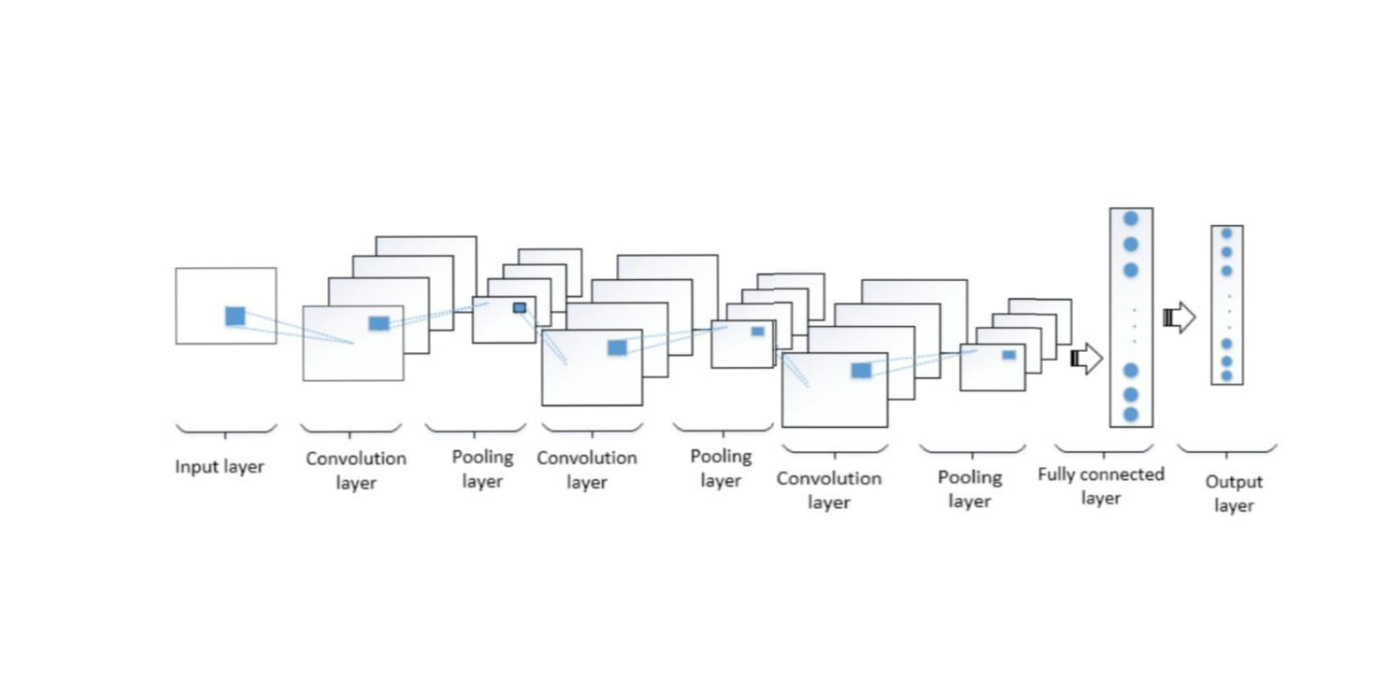

Epoch 1/20
75/75 [==============================] - 243s 3s/step - loss: 0.5568 - accuracy: 0.7613 - val_loss: 0.3102 - val_accuracy: 0.8814
Epoch 2/20
75/75 [==============================] - 243s 3s/step - loss: 0.2425 - accuracy: 0.9017 - val_loss: 0.2208 - val_accuracy: 0.9249
Epoch 3/20
75/75 [==============================] - 239s 3s/step - loss: 0.1463 - accuracy: 0.9454 - val_loss: 0.1106 - val_accuracy: 0.9644
Epoch 4/20
75/75 [==============================] - 243s 3s/step - loss: 0.0851 - accuracy: 0.9696 - val_loss: 0.1053 - val_accuracy: 0.9763
Epoch 5/20
75/75 [==============================] - 258s 3s/step - loss: 0.0589 - accuracy: 0.9800 - val_loss: 0.1604 - val_accuracy: 0.9565
Epoch 6/20
75/75 [==============================] - 274s 4s/step - loss: 0.0280 - accuracy: 0.9904 - val_loss: 0.1586 - val_accuracy: 0.9605
Epoch 7/20
75/75 [==============================] - 270s 4s/step - loss: 0.0431 - accuracy: 0.9842 - val_loss: 0.1064 - val_accuracy: 0.9842
Epoch 8/20
75

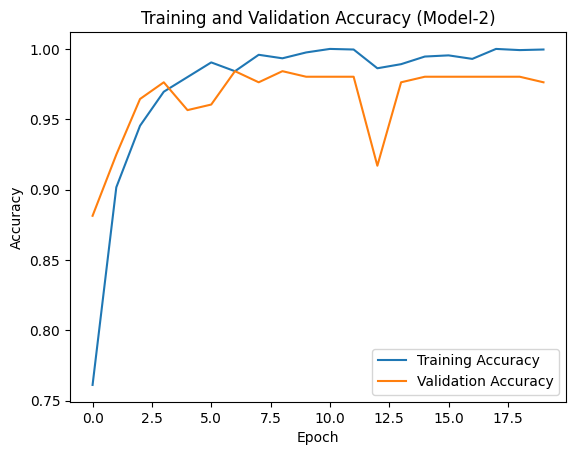

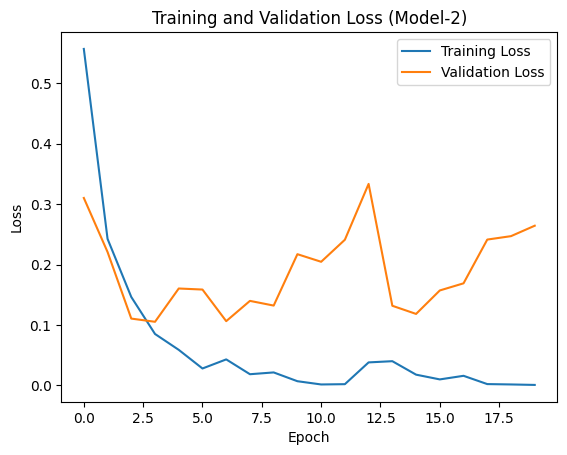

8/8 [==============================] - 5s 588ms/step - loss: 0.2642 - accuracy: 0.9763
Model-2 Evaluation:
Test Accuracy: 0.9762845635414124
Test Loss: 0.2642437815666199


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define Model-2
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(256, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model-2
history2 = model2.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator
)

# Plot the training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model-2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model-2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model-2 on the test set
evaluation2 = model2.evaluate(test_generator)
print("Model-2 Evaluation:")
print("Test Accuracy:", evaluation2[1])
print("Test Loss:", evaluation2[0])


### <b><font color="#dd11a3">Model-3 --> CNN with Multiple Layers + Dropout Regularization + Image Data Augmentation</font></b>

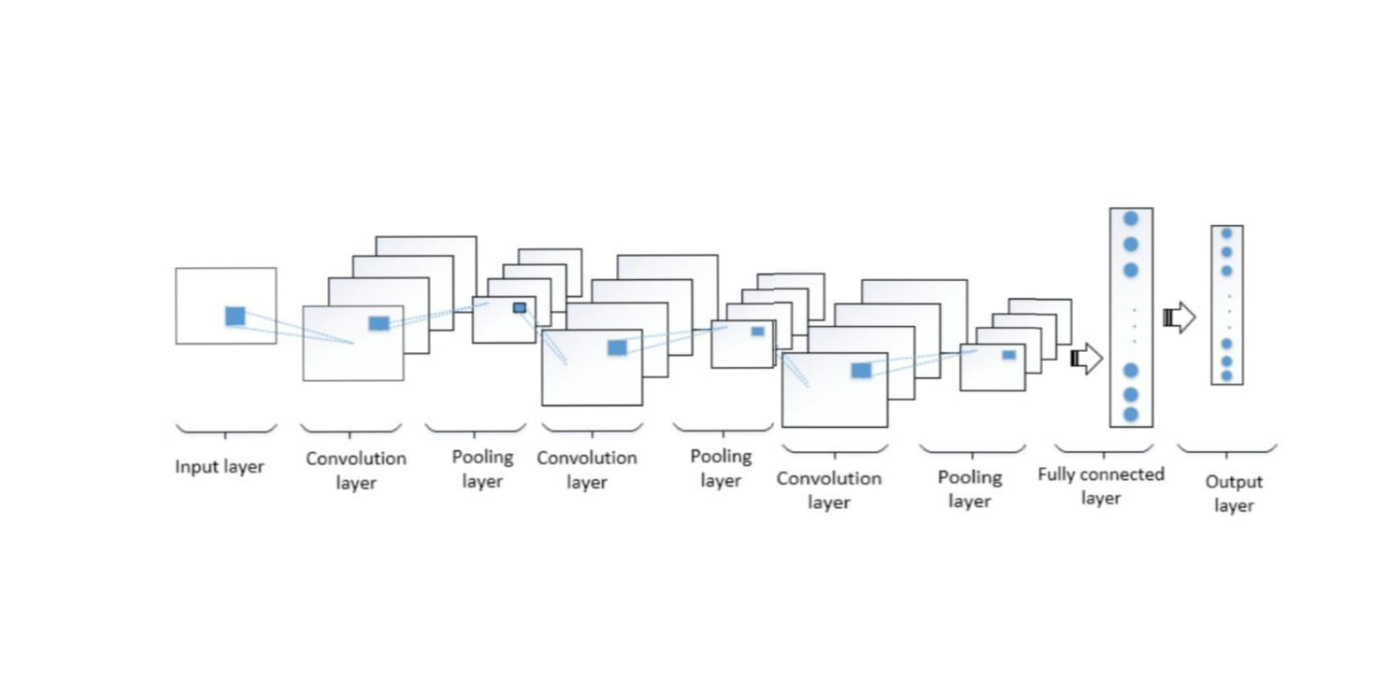

Found 2400 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Epoch 1/20
75/75 [==============================] - 292s 4s/step - loss: 0.6468 - accuracy: 0.6771 - val_loss: 0.4927 - val_accuracy: 0.7747
Epoch 2/20
75/75 [==============================] - 298s 4s/step - loss: 0.4804 - accuracy: 0.7833 - val_loss: 0.4202 - val_accuracy: 0.8103
Epoch 3/20
75/75 [==============================] - 299s 4s/step - loss: 0.4108 - accuracy: 0.8238 - val_loss: 0.5351 - val_accuracy: 0.7470
Epoch 4/20
75/75 [==============================] - 303s 4s/step - loss: 0.4043 - accuracy: 0.8250 - val_loss: 0.3408 - val_accuracy: 0.8498
Epoch 5/20
75/75 [==============================] - 304s 4s/step - loss: 0.3385 - accuracy: 0.8658 - val_loss: 0.3065 - val_accuracy: 0.8814
Epoch 6/20
75/75 [==============================] - 302s 4s/step - loss: 0.3079 - accuracy: 0.8692 - val_loss: 0.3690 - val_accuracy: 0.8538
Epoch 7/20
75/75 [==============================] - 293s 4s/step - loss

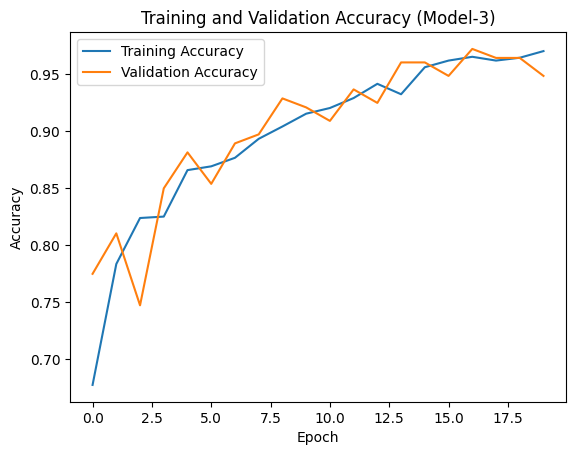

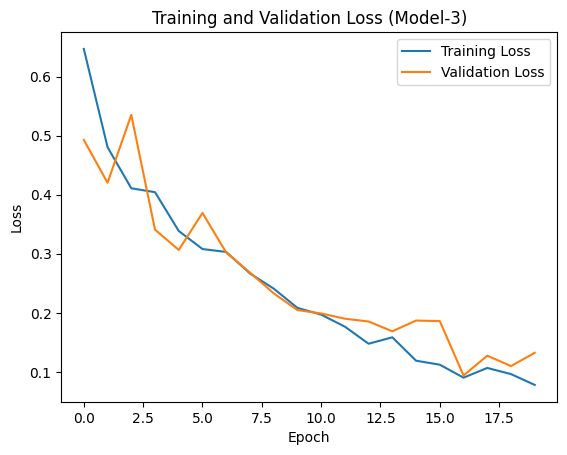

8/8 [==============================] - 4s 533ms/step - loss: 0.1323 - accuracy: 0.9486
Model-3 Evaluation:
Test Accuracy: 0.948616623878479
Test Loss: 0.132269486784935


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    'tumor_vs_healthy/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    'D:\\major_project\\BrainTumorProject\\test_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Define Model-3
model3 = Sequential()
model3.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(256, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model-3 with data augmentation
history3 = model3.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Print the summary of Model-3
model3.summary()

# Plot the training and validation accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model-3)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model-3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model-3 on the test set
evaluation3 = model3.evaluate(test_generator)
print("Model-3 Evaluation:")
print("Test Accuracy:", evaluation3[1])
print("Test Loss:", evaluation3[0])


### <b><font color="#dd11a3">Model-4 --> Transfer Learning with VGG16 + Data Augmentation for Feature Extraction</font></b>

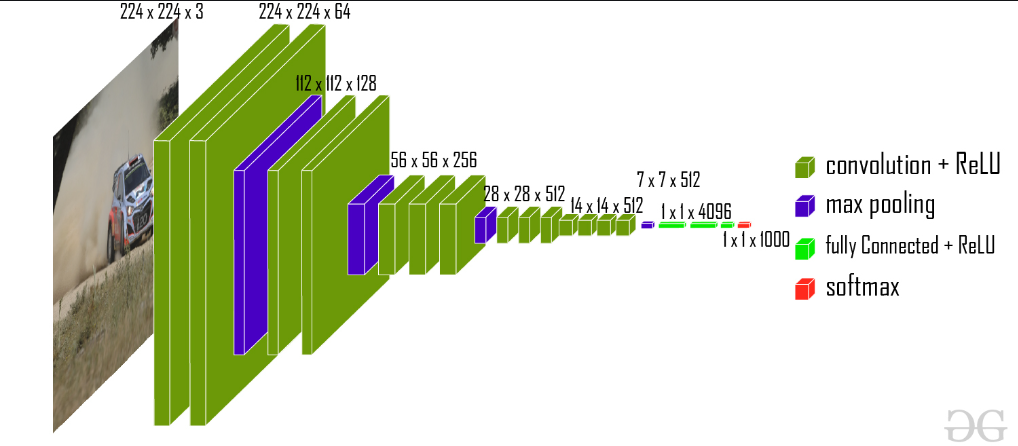

Found 2400 images belonging to 2 classes.
Found 253 images belonging to 2 classes.
Epoch 1/50
75/75 [==============================] - 243s 3s/step - loss: 0.7790 - accuracy: 0.7617 - val_loss: 0.3163 - val_accuracy: 0.8656
Epoch 2/50
75/75 [==============================] - 242s 3s/step - loss: 0.2685 - accuracy: 0.8921 - val_loss: 0.1815 - val_accuracy: 0.9328
Epoch 3/50
75/75 [==============================] - 243s 3s/step - loss: 0.2167 - accuracy: 0.9125 - val_loss: 0.2203 - val_accuracy: 0.9051
Epoch 4/50
75/75 [==============================] - 244s 3s/step - loss: 0.2143 - accuracy: 0.9150 - val_loss: 0.1555 - val_accuracy: 0.9328
Epoch 5/50
75/75 [==============================] - 244s 3s/step - loss: 0.1714 - accuracy: 0.9367 - val_loss: 0.1298 - val_accuracy: 0.9526
Epoch 6/50
75/75 [==============================] - 240s 3s/step - loss: 0.1530 - accuracy: 0.9417 - val_loss: 0.1258 - val_accuracy: 0.9565
Epoch 7/50
75/75 [==============================] - 240s 3s/step - loss

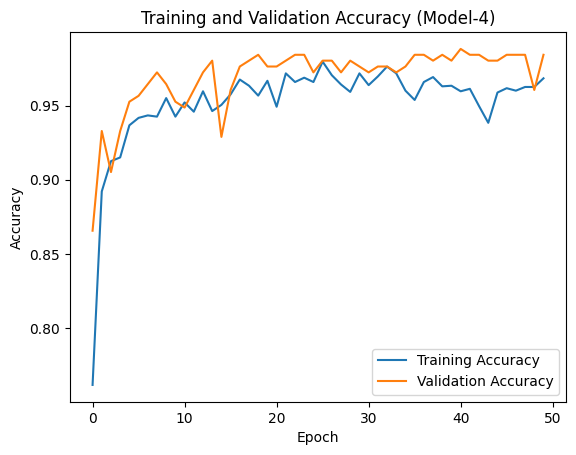

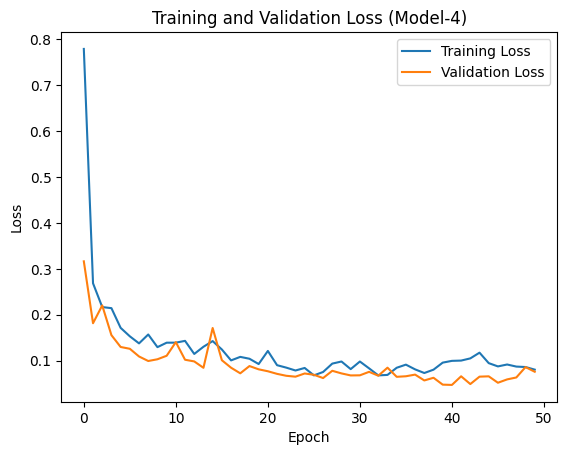

8/8 [==============================] - 33s 4s/step - loss: 0.0758 - accuracy: 0.9842
Model-4 Evaluation:
Test Accuracy: 0.9841897487640381
Test Loss: 0.07577162981033325


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Create a sequential model
model4 = Sequential()

# Add the pre-trained VGG16 model as a layer
model4.add(base_model)

# Flatten the output of VGG16
model4.add(Flatten())

# Add additional dense layers for classification
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define ImageDataGenerator for test data withou     t augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
    'tumor_vs_healthy/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Create the test generator
test_generator = test_datagen.flow_from_directory(
    'D:\\major_project\\BrainTumorProject\\test_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Train Model-4 with data augmentation
history4 = model4.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Print the summary of Model-4
model4.summary()

# Plot the training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model-4)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Model-4)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model-4 on the test set
evaluation4 = model4.evaluate(test_generator)
print("Model-4 Evaluation:")
print("Test Accuracy:", evaluation4[1])
print("Test Loss:", evaluation4[0])


In [6]:
pip install scikit-learn


   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
    --------------------------------------- 0.2/10.6 MB 4.6 MB/s eta 0:00:03
   - -------------------------------------- 0.5/10.6 MB 6.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/10.6 MB 5.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/10.6 MB 6.0 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/10.6 MB 6.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.6 MB 6.5 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/10.6 MB 6.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.0/10.6 MB 6.2 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.6 MB 6.0 MB/s eta 0:00:02
   --------- ------------------------------ 2.5/10.6 MB 6.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.8/10.6 MB 6.1 MB/s eta 0:00:02
   ------------ --------------------------- 3.3/10.6 MB 6.6 MB/s eta 0:00:02
   ---


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


8/8 [==============================] - 34s 4s/step
CNN Model Metrics:
Accuracy: 0.5375494071146245
Precision: 0.61875
Recall: 0.6387096774193548
F1 Score: 0.6285714285714286
AUC: 0.508130348913759
Confusion Matrix:
[[37 61]
 [56 99]]

VGG16 Model Metrics:
Accuracy: 0.549407114624506
Precision: 0.6305732484076433
Recall: 0.6387096774193548
F1 Score: 0.6346153846153846
AUC: 0.5234364713627386
Confusion Matrix:
[[40 58]
 [56 99]]


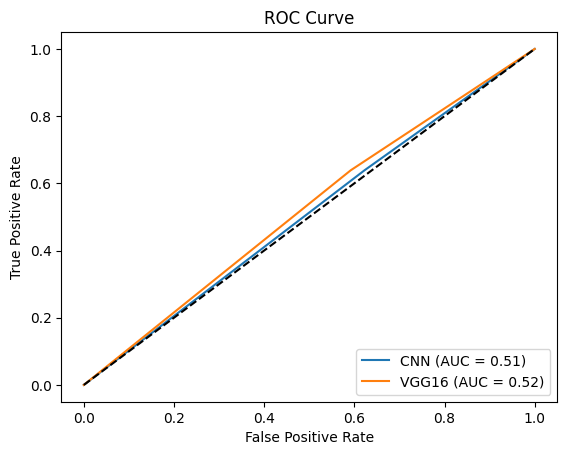

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Evaluate Model-3
predictions_cnn = model3.predict(test_generator)
predictions_cnn = (predictions_cnn > 0.5).astype(int)  # Convert probabilities to binary predictions

accuracy_cnn = accuracy_score(test_generator.classes, predictions_cnn)
precision_cnn = precision_score(test_generator.classes, predictions_cnn)
recall_cnn = recall_score(test_generator.classes, predictions_cnn)
f1_score_cnn = f1_score(test_generator.classes, predictions_cnn)
fpr_cnn, tpr_cnn, _ = roc_curve(test_generator.classes, predictions_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)
conf_matrix_cnn = confusion_matrix(test_generator.classes, predictions_cnn)

# Evaluate Model-4
predictions_vgg16 = model4.predict(test_generator)
predictions_vgg16 = (predictions_vgg16 > 0.5).astype(int)

accuracy_vgg16 = accuracy_score(test_generator.classes, predictions_vgg16)
precision_vgg16 = precision_score(test_generator.classes, predictions_vgg16)
recall_vgg16 = recall_score(test_generator.classes, predictions_vgg16)
f1_score_vgg16 = f1_score(test_generator.classes, predictions_vgg16)
fpr_vgg16, tpr_vgg16, _ = roc_curve(test_generator.classes, predictions_vgg16)
auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)
conf_matrix_vgg16 = confusion_matrix(test_generator.classes, predictions_vgg16)

# Print and plot the metrics
print("CNN Model Metrics:")
print("Accuracy:", accuracy_cnn)
print("Precision:", precision_cnn)
print("Recall:", recall_cnn)
print("F1 Score:", f1_score_cnn)
print("AUC:", auc_cnn)
print("Confusion Matrix:")
print(conf_matrix_cnn)

print("\nVGG16 Model Metrics:")
print("Accuracy:", accuracy_vgg16)
print("Precision:", precision_vgg16)
print("Recall:", recall_vgg16)
print("F1 Score:", f1_score_vgg16)
print("AUC:", auc_vgg16)
print("Confusion Matrix:")
print(conf_matrix_vgg16)

# Plot ROC curves
plt.figure()
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc_cnn:.2f})')
plt.plot(fpr_vgg16, tpr_vgg16, label=f'VGG16 (AUC = {auc_vgg16:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


calculate Specificity and Negative Predictive Value using the confusion matrix 

In [9]:

tn_cnn, fp_cnn, fn_cnn, tp_cnn = conf_matrix_cnn.ravel()
specificity_cnn = tn_cnn / (tn_cnn + fp_cnn)
print("specificity of cnn model is: ",specificity_cnn  )


tn_vgg16, fp_vgg16, fn_vgg16, tp_vgg16 = conf_matrix_vgg16.ravel()
specificity_vgg16 = tn_vgg16 / (tn_vgg16 + fp_vgg16)
print("specificity of vgg16 model is: ",specificity_vgg16)

specificity of cnn model is:  0.37755102040816324
specificity of vgg16 model is:  0.40816326530612246


 Sensitivity (True Positive Rate) and Positive Predictive Value (p Value)

In [10]:
# Calculate Sensitivity (True Positive Rate) and Positive Predictive Value (p Value) for CNN model
sensitivity_cnn = recall_cnn
p_value_cnn = precision_cnn
print("sensitivity of cnn is:",sensitivity_cnn)
print("p_value of cnn is:",p_value_cnn)

# Calculate Sensitivity (True Positive Rate) and Positive Predictive Value (p Value) for VGG16 model
sensitivity_vgg16 = recall_vgg16
p_value_vgg16 = precision_vgg16
print("sensitivity of vgg16 is:",sensitivity_vgg16)
print("p_value of vgg16 is:",p_value_vgg16)



sensitivity of cnn is: 0.6387096774193548
p_value of cnn is: 0.61875
sensitivity of vgg16 is: 0.6387096774193548
p_value of vgg16 is: 0.6305732484076433


In [5]:

model4.save("D:\\major_project\\BrainTumorProject\\save_model4.h5",save_format="h5")

c:\Users\madhu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
model4.save('D:\\major_project\\BrainTumorProject\\my_model4.keras')

# <font color="gray">Making a few Sample Predictions</font>

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


In [12]:
def predict_tumor(img_path):
    # load the image
    img = load_img(img_path,target_size=(224,224))
    # convert to array
    img = img_to_array(img)/255
    img_array = np.array([img])
    plt.imshow(img_array[0])
    plt.show()
    best = load_model("D:\\major_project\\BrainTumorProject\\my_model4.keras")
    if best.predict(img_array)[0][0]>0.4:
        print("The image indicates presence of Brain tumor")
    else:
        print("This is a Healthy Brain")
    print(best.predict(img_array)[0][0])

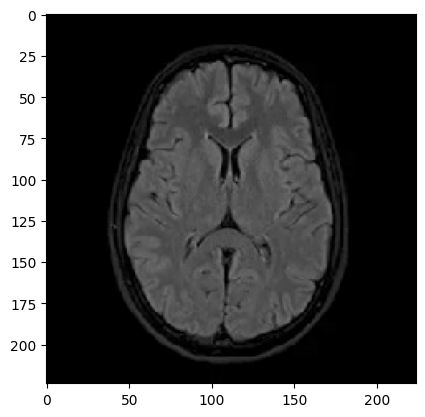

1/1 [==============================] - 0s 317ms/step
This is a Healthy Brain
1/1 [==============================] - 0s 138ms/step
0.00069352216


In [13]:
predict_tumor("D:\major_project\BrainTumorProject\pred\pred0.jpg")

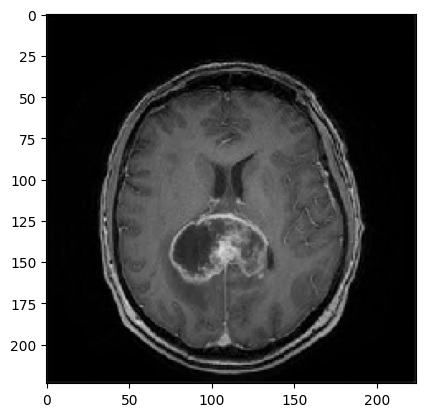

1/1 [==============================] - 0s 241ms/step
The image indicates presence of Brain tumor
1/1 [==============================] - 0s 141ms/step
0.99995375


In [14]:
predict_tumor("D:\major_project\BrainTumorProject\pred\pred6.jpg")

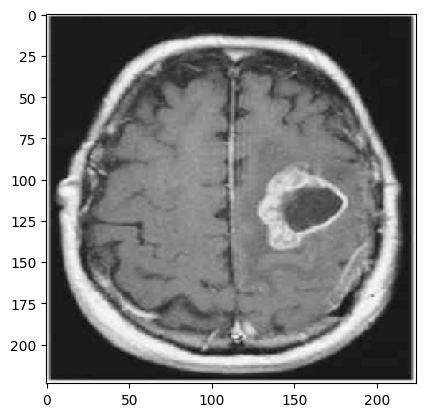

1/1 [==============================] - 0s 238ms/step
The image indicates presence of Brain tumor
1/1 [==============================] - 0s 140ms/step
0.99970096


In [15]:
predict_tumor("D:\major_project\BrainTumorProject\pred\pred45.jpg")

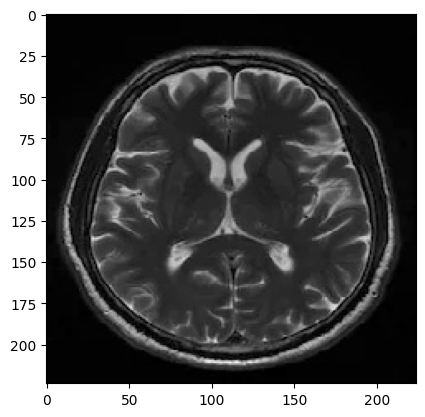

1/1 [==============================] - 0s 250ms/step
This is a Healthy Brain
1/1 [==============================] - 0s 139ms/step
0.0017991533


In [16]:
predict_tumor("D:\major_project\BrainTumorProject\pred\pred29.jpg")

ACCURACY AND LOSS OF DIFFERENT MODELS

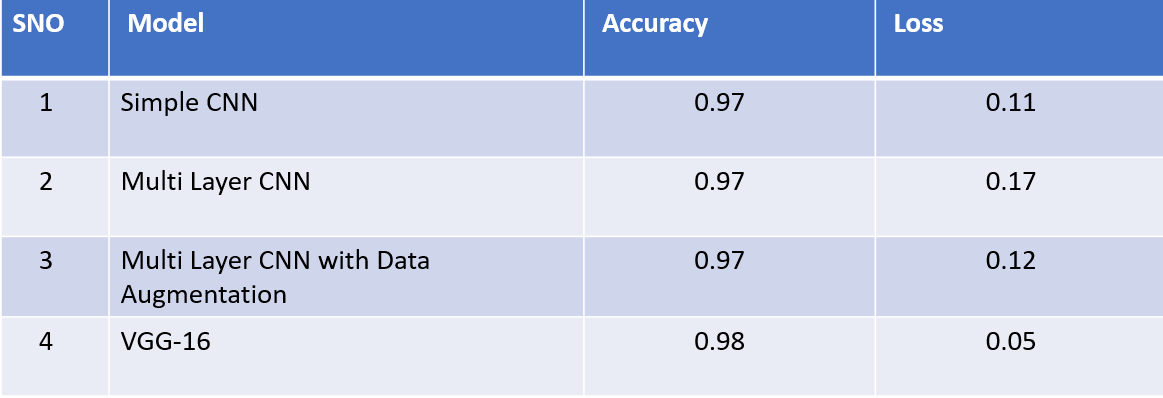

In the presence of the ReLU activation function and a learning rate of 0.0009500000451225787, the modelle-1, ie.simple CNN, attained an accuracy of 0.97 and a loss of 0.11.

In the presence of the ReLU activation function and a learning rate of 0.0009500000451225787, the modle-2 ie. Multi layer CNN, attained an accuracy of 0.97 and a loss of 0.17.

In the presence of the ReLU activation function and a learning rate of 0.0009500000451225787, the modle-3 ie. Multi layer CNN with agumented datset, attained an accuracy of 0.97 and a loss of 0.12.

In the presence of the ReLU activation function and a learning rate of 0.0009500000451225787, the modle-4 ie. VGG-16 , attained an accuracy of 0.98 and a loss of 0.05.



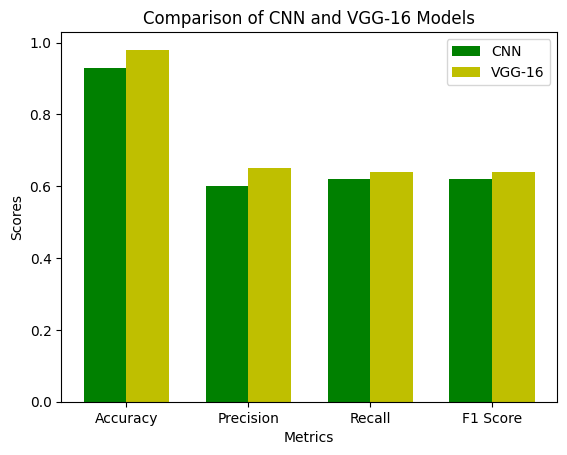

In [5]:
import matplotlib.pyplot as plt

# Parameters
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
CNN_values = [0.93, 0.60, 0.62, 0.62]
VGG16_values = [0.98, 0.65, 0.64, 0.64]

# Plotting the bars
bar_width = 0.35
index = range(len(metrics))

plt.bar(index, CNN_values, bar_width, label='CNN', color='g')
plt.bar([i + bar_width for i in index], VGG16_values, bar_width, label='VGG-16', color='y')

# Adding labels
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of CNN and VGG-16 Models')
plt.xticks([i + bar_width/2 for i in index], metrics)
plt.legend()

# Displaying the graph
plt.show()


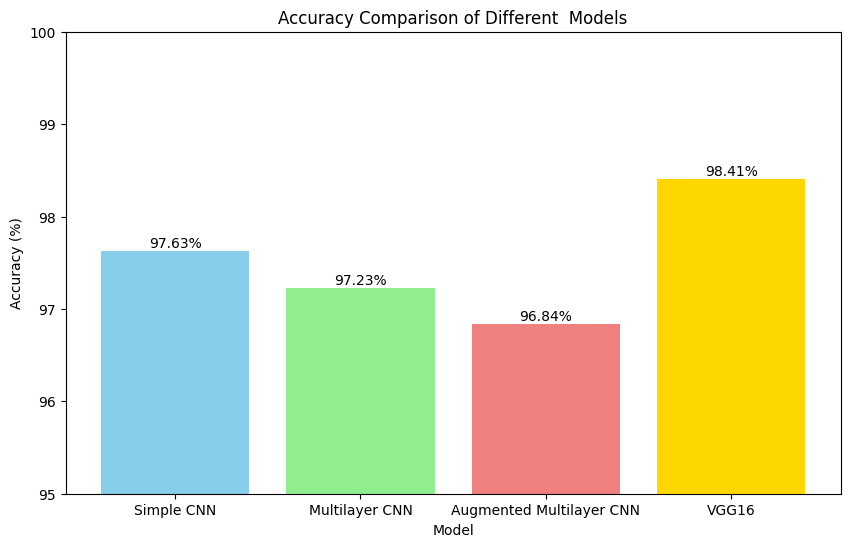

In [14]:
import matplotlib.pyplot as plt

# Model names and their corresponding accuracies
models = ['Simple CNN', 'Multilayer CNN', 'Augmented Multilayer CNN', 'VGG16']
accuracies = [97.63, 97.23, 96.84, 98.41]

# Define custom colors for each bar
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

# Plotting the bars
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different  Models')
plt.ylim(95, 100)  # Adjusting the y-axis limit for better visualization

# Adding text labels for each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy}%', ha='center', va='bottom')

# Displaying the graph
plt.show()
